# Map Matching & Feature engineering for lane, intersection etc

In [41]:
'''
Feature Engineering:
Identify intersections and compute the lane count.
Calculate distance between intersections.
Map Matching with GPS Data:
Map each GPS point to a road segment.
Analyze travel time, delays, or average speed on each segment.
'''

'\nFeature Engineering:\nIdentify intersections and compute the lane count.\nCalculate distance between intersections.\nMap Matching with GPS Data:\nMap each GPS point to a road segment.\nAnalyze travel time, delays, or average speed on each segment.\n'

In [2]:
pip install osmnx geopandas shapely scikit-mobility movingpandas


Note: you may need to restart the kernel to use updated packages.


In [3]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString
from scipy.spatial import KDTree


In [4]:
# Example GPS data
data = {
    'latitude': [37.7749, 37.7750, 37.7751], 
    'longitude': [-122.4194, -122.4195, -122.4196]
}
gps_df = pd.DataFrame(data)
gps_df['geometry'] = gps_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
gps_gdf = gpd.GeoDataFrame(gps_df, geometry='geometry', crs="EPSG:4326")


In [5]:
import osmnx as ox
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

# Create a custom session with SSL verification disabled
session = requests.Session()
session.verify = False  # Disable SSL verification

# Set up retries for the session
retry = Retry(connect=3, backoff_factor=0.5)
adapter = HTTPAdapter(max_retries=retry)
session.mount("https://", adapter)
session.mount("http://", adapter)

# Apply this session to the settings for OSMnx
ox.settings.requests_kwargs = {"verify": False}

# Load road network for Nanjing
G = ox.graph_from_place("Nanjing, China", network_type="drive")

# Convert the network graph to GeoDataFrames for nodes and edges
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)


In [6]:
# Create a KDTree for the edges
edge_coords = [(row.geometry.centroid.x, row.geometry.centroid.y) for _, row in edges.iterrows()]
edge_tree = KDTree(edge_coords)

# Map match each GPS point
def map_match(gps_point):
    nearest_idx = edge_tree.query((gps_point.x, gps_point.y), k=1)[1]
    nearest_edge = edges.iloc[nearest_idx]
    return nearest_edge['geometry']

gps_gdf['matched_road'] = gps_gdf['geometry'].apply(map_match)


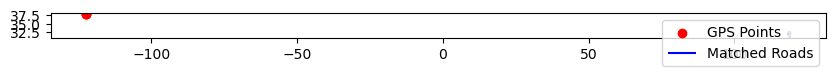

In [7]:
import matplotlib.pyplot as plt

# Plot road network, original GPS points, and matched points
fig, ax = plt.subplots(figsize=(10, 10))
edges.plot(ax=ax, linewidth=1, color="gray")
gps_gdf.plot(ax=ax, color="red", label="GPS Points")
gps_gdf.set_geometry('matched_road').plot(ax=ax, color="blue", label="Matched Roads")
plt.legend()
plt.show()


## Calculate number of intersection

In [9]:
'''
Here’s a recap of the features we engineered:

Intersection Density: Number or distance of intersections in each segment.
Lane Count: Number of lanes for each road segment.
Road Type: Road classification (e.g., residential, primary).
Segment Length: Length of each segment between intersections.
Curvature: Degree of road curvature.
Speed Limit: Estimated or actual speed limit
'''

'\nHere’s a recap of the features we engineered:\n\nIntersection Density: Number or distance of intersections in each segment.\nLane Count: Number of lanes for each road segment.\nRoad Type: Road classification (e.g., residential, primary).\nSegment Length: Length of each segment between intersections.\nCurvature: Degree of road curvature.\nSpeed Limit: Estimated or actual speed limit\n'

In [10]:
# Calculate the number of intersections within each road segment
nodes['is_intersection'] = nodes['street_count'] > 1  # A node with more than 1 street count is an intersection
intersection_count = nodes['is_intersection'].sum()
print("Total intersections:", intersection_count)


Total intersections: 26297


 ## Lane counts

In [12]:
# Check for 'lanes' attribute in edges
# Use the first element if it's a list or fill with a default value of 1
edges['lanes'] = edges['lanes'].apply(lambda x: x[0] if isinstance(x, list) and x else 1)

# Convert to integer
edges['lanes'] = edges['lanes'].astype(int)


## Road types

In [14]:
# Extract road type for each edge
edges['road_type'] = edges['highway']


## Calculate length segment

In [16]:
# Calculate the length of each road segment
edges['length'] = edges['geometry'].length


C:\Users\Admin\AppData\Local\Temp\ipykernel_9732\1915609566.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  edges['length'] = edges['geometry'].length


## Calculate curvature of road 

In [18]:
# Calculate curvature as ratio of length to Euclidean distance
edges['curvature'] = edges['geometry'].apply(
    lambda geom: (
        geom.length / Point(geom.coords[0]).distance(Point(geom.coords[-1]))
        if Point(geom.coords[0]).distance(Point(geom.coords[-1])) != 0 else None  # Set to None or another default value
    )
)


## Set speed where value is missing

In [20]:
# Set speed limit, with a default value where missing
edges['speed_kph'] = edges['maxspeed'].fillna(30)  # Default 30 km/h where data is missing


## Select relevant features for the dataset 

In [22]:
# Select the relevant features for the dataset
features_df = edges[['length', 'lanes', 'road_type', 'speed_kph', 'curvature']]

# Reset index for easier handling in a DataFrame
features_df.reset_index(drop=True, inplace=True)

print(features_df.head(5))


     length  lanes     road_type speed_kph  curvature
0  0.001254      1   residential        30   1.000000
1  0.004554      1   residential        30   1.013330
2  0.004043      1      tertiary        30   1.035975
3  0.003984      1  unclassified        30   1.017269
4  0.001254      1   residential        30   1.000000


## Plot road network with lane counts as color

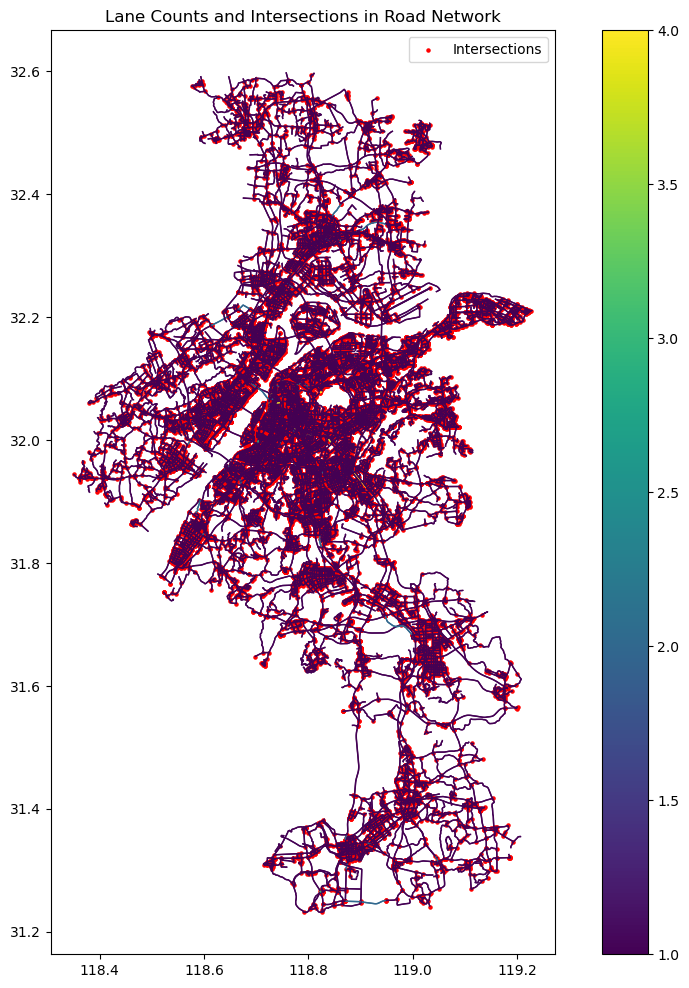

In [24]:
# Plot road network with lane counts as color
fig, ax = plt.subplots(figsize=(12, 12))
edges.plot(ax=ax, column='lanes', legend=True, cmap='viridis', linewidth=1)
nodes[nodes['is_intersection']].plot(ax=ax, color='red', markersize=5, label='Intersections')
plt.legend()
plt.title("Lane Counts and Intersections in Road Network")
plt.show()
